In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

import os
os.chdir("..")
from Analysis.utils import filter_opto_data, smooth
from AnalysisTables.decoding_tables import ClusterlessAheadBehindDistance
from ms_opto_stim_protocol import OptoStimProtocol

import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Control Animal examples


In [4]:
# filter_opto_data({"animal": "Yoshi", "track_type": "early_wtrack"})

# nwb_file_name = "Yoshi20220517_.nwb"
# pos_interval = "pos 11 valid times"

nwb_file_name = "Wallie20220922_.nwb"
pos_interval = "pos 3 valid times"
posterior_fit = "acausal"

key = {"nwb_file_name": nwb_file_name, "interval_list_name": pos_interval}
clusterless_key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + pos_interval,
    "encoding_interval": pos_interval,
}

ClusterlessDecodingV1 & clusterless_key

pos_df = ClusterlessDecodingV1().fetch_linear_position_info(clusterless_key)
results = (ClusterlessDecodingV1() & clusterless_key).fetch_results()


if posterior_fit == "acausal":
    results = results.acausal_posterior
elif posterior_fit == "causal":
    results = results.causal_posterior
else:
    raise ValueError("Invalid posterior_fit: {}".format(posterior_fit))
unstacked_result_states = results.unstack("state_bins")
states = unstacked_result_states.state.values
state_probabilities = unstacked_result_states.sum("position")[0]
position_posterior = unstacked_result_states.sum("state")[0]
decode_pos = position_posterior.idxmax("position").values
# decode_pos = [pos_df.index.values[i] for i in decode_pos]

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": pos_interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

spikes = ClusterlessDecodingV1().fetch_spike_data(clusterless_key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 30, 150)


decode_dist = (
    (ClusterlessAheadBehindDistance() & clusterless_key)
    .fetch1_dataframe()
    .decode_distance.values
)

[2024-12-18 08:02:22,440][WARNING]: Skipped checksum for file with hash: 85c41671-2cbf-58d8-f178-fe2d4830eb26, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_872dd7d0-e543-4f73-ab32-00f37b6e0b4a.nc
[2024-12-18 08:02:37,522][WARNING]: Skipped checksum for file with hash: 404c68d5-3683-08d3-cc08-65781f5f8882, and path: /stelmo/nwb/raw/Wallie20220922_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/

In [5]:
entropy_i = -np.sum(position_posterior * np.log(position_posterior), axis=-1).values
entropy_i = smooth(entropy_i, 10, 150)
from Analysis.utils import filter_position_ports, get_running_valid_intervals

non_port = filter_position_ports(opto_key, dlc=True)
non_port = get_running_valid_intervals(opto_key, dlc_pos=True)

t0 = non_port[0][1][0]

Text(0.0, 1.0, 'Posterior Entropy')

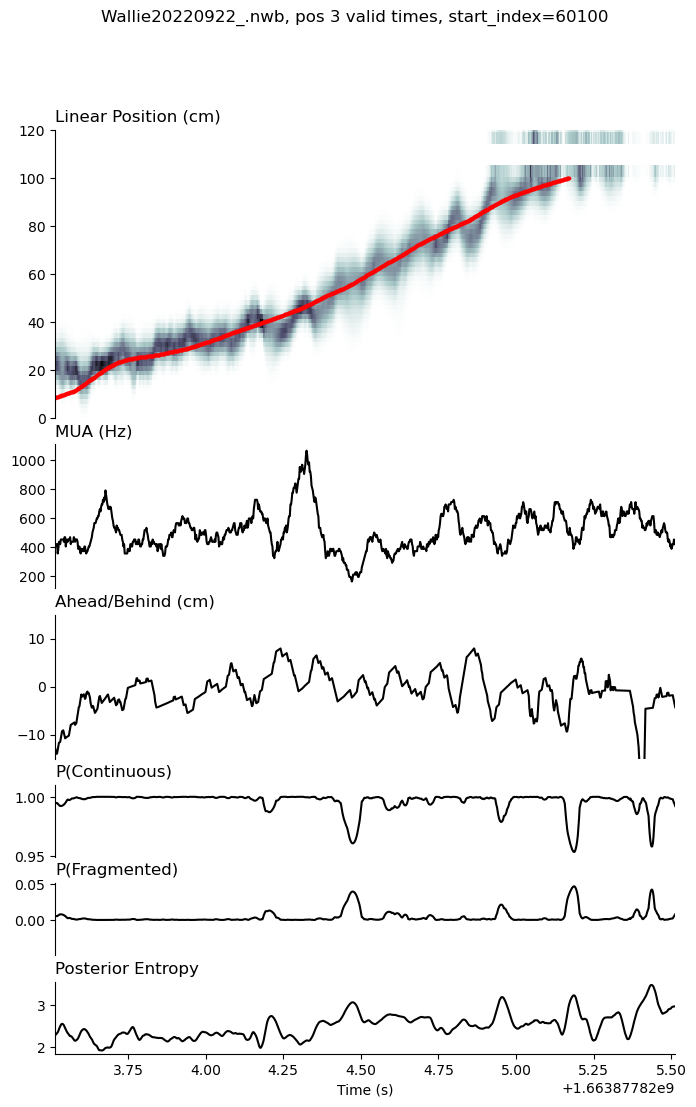

In [22]:
show_stim = False
t0 = non_port[0][12][0]
st = np.digitize(t0, pos_df.index.values)
ind = slice(st - 1000, st + 0, None)
track_lim = (0, 120)
# ind = slice(st -1000, st + 1000, None)
# track_lim = (0, 250)


t_plot = pos_df.index.values[ind]

fig, ax_list = plt.subplots(
    6, 1, figsize=(8, 12), sharex=False, height_ratios=[4, 2, 2, 1, 1, 1]
)
decode_ax = ax_list[0]
mua_ax = ax_list[1]
dist_ax = ax_list[2]
cont_decode_ax = ax_list[3]
frag_decode_ax = ax_list[4]
entropy_ax = ax_list[5]

# posterior distribution and true values
pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
decode_ax.pcolormesh(
    XX, YY, position_posterior[ind].T, cmap="bone_r", shading="nearest"
)
decode_ax.scatter(t_plot, linear_pos[ind], color="r", s=3)
# decode_ax.scatter(t_plot, decode_pos[ind], color="teal", s=3)
decode_ax.set_ylim(track_lim)

# mua
mua_ax.plot(t_plot, mua[ind] / np.mean(np.diff(t_plot)), color="k")
# decode distance
dist_ax.plot(t_plot, smooth(decode_dist, 2, 10)[ind], color="k")
dist_ax.set_ylim(-15, 15)
# p(continous)
val = state_probabilities[ind, 0]
mid = np.median(val)
scale = 0.05
rng = mid - scale, min(mid + scale, 1.01)
cont_decode_ax.plot(t_plot, val, color="k")
cont_decode_ax.set_ylim(rng)
# p(frag)
val = state_probabilities[ind, 1]
mid = np.median(val)
scale = 0.05
rng = mid - scale, min(mid + scale, 1.01)
frag_decode_ax.plot(t_plot, val, color="k")
frag_decode_ax.set_ylim(rng)

# entropy
entropy_ax.plot(t_plot, entropy_i[ind], color="k")

if show_stim:
    plot_marks = stim_time[stim == 1]
    plot_marks = plot_marks[(plot_marks > t_plot[0]) & (plot_marks < t_plot[-1])]
    for ax in ax_list:
        ax.vlines(plot_marks, *ax.get_ylim(), color="thistle", alpha=0.5, lw=2)

for ax in ax_list:
    ax.set_xlim(t_plot[0], t_plot[-1])

for ax in ax_list[:-1]:
    ax.spines[["top", "right", "bottom"]].set_visible(False)
    ax.set_xticks([])
ax_list[-1].spines[["top", "right"]].set_visible(False)
ax_list[-1].set_xlabel("Time (s)")

fig.suptitle(
    f"{nwb_file_name}, {pos_interval}, start_index={st}",
)

# AXIS LABELING OPTIONS
# mua_ax.set_ylabel("MUA (Hz)")
# dist_ax.set_ylabel("Ahead/Behind (cm)")
# decode_ax.set_ylabel("Linear Position (cm)")
# cont_decode_ax.set_ylabel("P(Continuous)")
# frag_decode_ax.set_ylabel("P(Fragmented)")
# entropy_ax.set_ylabel("Posterior Entropy")

mua_ax.set_title("MUA (Hz)", loc="left")
dist_ax.set_title("Ahead/Behind (cm)", loc="left")
decode_ax.set_title("Linear Position (cm)", loc="left")
cont_decode_ax.set_title("P(Continuous)", loc="left")
frag_decode_ax.set_title("P(Fragmented)", loc="left")
entropy_ax.set_title("Posterior Entropy", loc="left")

In [23]:
plt.rcParams['svg.fonttype'] = 'none'
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
fig.savefig(f"Figures_20241201/wtrack_examples_{nwb_file_name.split('_')[0]}_{pos_interval}_index{st}"
            + f"{'_stim' if show_stim else ''}.svg")

In [20]:
os.listdir()

['datajoint_linter',
 'moseq_test_proj_v0',
 '.vscode',
 'position_tools',
 'moseq_test_proj',
 'spikegadgets_to_nwb',
 'NEW_rec_to_nwb',
 'moseq_test_proj2',
 'dual_channel_proof_notes.pdf',
 'env_exports',
 '.ipynb_checkpoints',
 'spyglassTutorial_1.ipynb',
 'spyglass-export-docker',
 'neurosift',
 'Statistics-Epilepsy-Book',
 'spyglass_custom',
 'cpc_spikes',
 'kenny_debug_converter.ipynb',
 'SC66_0701_SBedit.yml',
 'medium_report_2.txt',
 'spyglass',
 'parallel_spikesorting',
 'trodes_to_nwb',
 'ucsf_transfer',
 'moseq_test_vids',
 'lfads',
 'spyglass_napari',
 'data_sharing',
 'dual_channel_proof_notes.py',
 'raster_decode_for_xulu.ipynb',
 'rec_to_binaries',
 'behavioral_analysis_AS',
 'NoMachine',
 'MS_analysis',
 'medium_report.txt',
 'c3po',
 'ms.ipynb',
 'spyglass-export-docker.zip',
 'MS_analysis_samsplaying',
 'MS_analysis_samsplaying (copy)',
 'rec_to_nwb.log',
 'Chris_Demo',
 'rec_to_nwb_frankLab',
 'port_traffic_monitor.sh',
 'kachery-cloud',
 'analysis_file_audit.ipynb'

# Test animal example

In [24]:
# filter_opto_data({"animal": "Yoshi", "track_type": "early_wtrack"})

# nwb_file_name = "Yoshi20220517_.nwb"
# pos_interval = "pos 11 valid times"

nwb_file_name = "Winnie20220719_.nwb"
pos_interval = "pos 3 valid times"


key = {"nwb_file_name": nwb_file_name, "interval_list_name": pos_interval}
clusterless_key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + pos_interval,
    "encoding_interval": pos_interval,
}

ClusterlessDecodingV1 & clusterless_key

pos_df = ClusterlessDecodingV1().fetch_linear_position_info(clusterless_key)
results = (ClusterlessDecodingV1() & clusterless_key).fetch_results()
posterior_fit = "acausal"

if posterior_fit == "acausal":
    results = results.acausal_posterior
elif posterior_fit == "causal":
    results = results.causal_posterior
else:
    raise ValueError("Invalid posterior_fit: {}".format(posterior_fit))
unstacked_result_states = results.unstack("state_bins")
states = unstacked_result_states.state.values
state_probabilities = unstacked_result_states.sum("position")[0]
position_posterior = unstacked_result_states.sum("state")[0]
decode_pos = position_posterior.idxmax("position").values
# decode_pos = [pos_df.index.values[i] for i in decode_pos]

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": pos_interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

spikes = ClusterlessDecodingV1().fetch_spike_data(clusterless_key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 30, 150)


decode_dist = (
    (ClusterlessAheadBehindDistance() & clusterless_key)
    .fetch1_dataframe()
    .decode_distance.values
)

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
[2024-12-18 08:14:58,743][WARNING]: Skipped checksum for file with hash: b8728e1b-151c-6312-0809-6d6cd6900bd2, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_89e4a112-1e04-4a7e-b65e-01d4093b8431.nc
[2024-12-18 08:15:17,549][WARNING]: Skipped checksum for file with hash: 6ffccb1d-60cb-2b9e-f84a-b61d2483a2ad, and path: /stelmo/nwb/raw/Winnie20220719_.nwb
/home/sambray/mambaforge-pypy

In [25]:
entropy_i = -np.sum(position_posterior * np.log(position_posterior), axis=-1).values
entropy_i = smooth(entropy_i, 10, 50)
from Analysis.utils import filter_position_ports, get_running_valid_intervals

non_port = filter_position_ports(opto_key, dlc=True)
non_port = get_running_valid_intervals(opto_key, dlc_pos=True)

t0 = non_port[0][1][0]

Text(0.0, 1.0, 'Posterior Entropy')

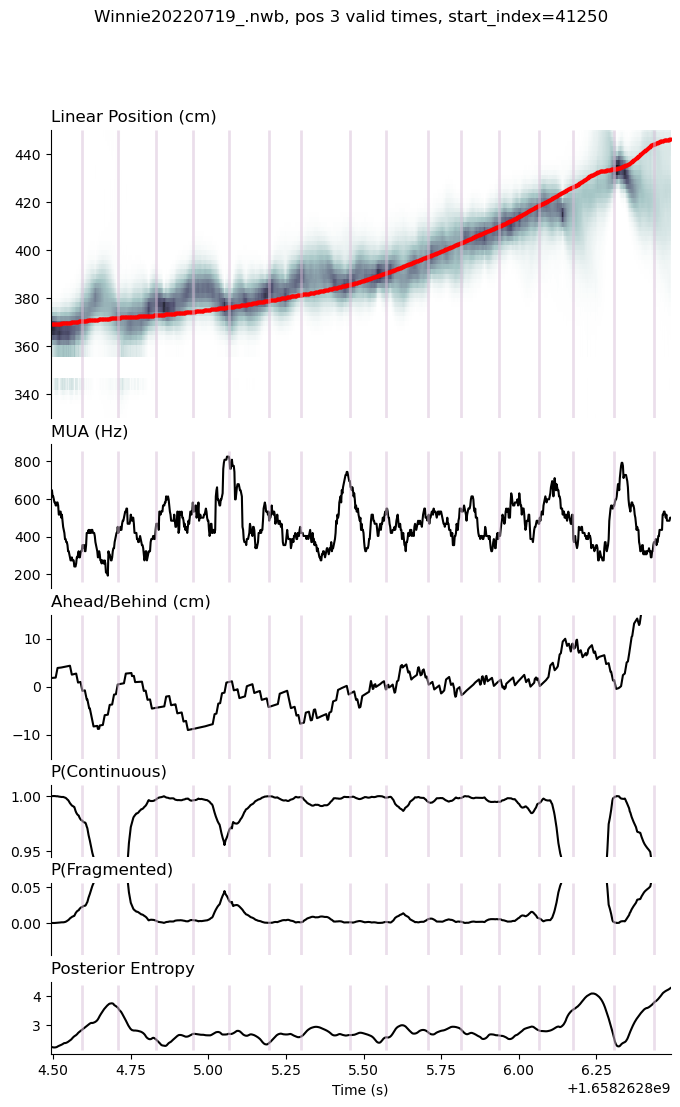

In [28]:
show_stim = True
track_lim = (0, 450)

t0 = non_port[0][42][0]
st = np.digitize(t0, pos_df.index.values)
ind = slice(st + 500, st + 1500, None)
track_lim = (330, 450)
# ind = slice(st -1000, st + 1000, None)
# track_lim = (0, 250)


t_plot = pos_df.index.values[ind]

fig, ax_list = plt.subplots(
    6, 1, figsize=(8, 12), sharex=False, height_ratios=[4, 2, 2, 1, 1, 1]
)
decode_ax = ax_list[0]
mua_ax = ax_list[1]
dist_ax = ax_list[2]
cont_decode_ax = ax_list[3]
frag_decode_ax = ax_list[4]
entropy_ax = ax_list[5]

# posterior distribution and true values
pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
decode_ax.pcolormesh(
    XX, YY, position_posterior[ind].T, cmap="bone_r", shading="nearest"
)
decode_ax.scatter(t_plot, linear_pos[ind], color="r", s=3)
# decode_ax.scatter(t_plot, decode_pos[ind], color="teal", s=3)
decode_ax.set_ylim(track_lim)

# mua
mua_ax.plot(t_plot, mua[ind] / np.mean(np.diff(t_plot)), color="k")
# decode distance
dist_ax.plot(t_plot, smooth(decode_dist, 2, 10)[ind], color="k")
dist_ax.set_ylim(-15, 15)
# p(continous)
val = state_probabilities[ind, 0]
mid = np.median(val)
scale = 0.05
rng = mid - scale, min(mid + scale, 1.01)
cont_decode_ax.plot(t_plot, val, color="k")
cont_decode_ax.set_ylim(rng)
# p(frag)
val = state_probabilities[ind, 1]
mid = np.median(val)
scale = 0.05
rng = mid - scale, min(mid + scale, 1.01)
frag_decode_ax.plot(t_plot, val, color="k")
frag_decode_ax.set_ylim(rng)

# entropy
entropy_ax.plot(t_plot, entropy_i[ind], color="k")

if show_stim:
    plot_marks = stim_time[stim == 1]
    plot_marks = plot_marks[(plot_marks > t_plot[0]) & (plot_marks < t_plot[-1])]
    for ax in ax_list:
        ax.vlines(plot_marks, *ax.get_ylim(), color="thistle", alpha=0.5, lw=2)

for ax in ax_list:
    ax.set_xlim(t_plot[0], t_plot[-1])

for ax in ax_list[:-1]:
    ax.spines[["top", "right", "bottom"]].set_visible(False)
    ax.set_xticks([])
ax_list[-1].spines[["top", "right"]].set_visible(False)
ax_list[-1].set_xlabel("Time (s)")

fig.suptitle(
    f"{nwb_file_name}, {pos_interval}, start_index={st}",
)

# AXIS LABELING OPTIONS
# mua_ax.set_ylabel("MUA (Hz)")
# dist_ax.set_ylabel("Ahead/Behind (cm)")
# decode_ax.set_ylabel("Linear Position (cm)")
# cont_decode_ax.set_ylabel("P(Continuous)")
# frag_decode_ax.set_ylabel("P(Fragmented)")
# entropy_ax.set_ylabel("Posterior Entropy")

mua_ax.set_title("MUA (Hz)", loc="left")
dist_ax.set_title("Ahead/Behind (cm)", loc="left")
decode_ax.set_title("Linear Position (cm)", loc="left")
cont_decode_ax.set_title("P(Continuous)", loc="left")
frag_decode_ax.set_title("P(Fragmented)", loc="left")
entropy_ax.set_title("Posterior Entropy", loc="left")

In [29]:
plt.rcParams['svg.fonttype'] = 'none'
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
fig.savefig(f"Figures_20241201/wtrack_examples_{nwb_file_name.split('_')[0]}_{pos_interval}_index{st}"
            + f"{'_stim' if show_stim else ''}.svg")